# 05. Transfer Learning in TensorFlow Part 2: Fine-tuning Exercises

In [ ]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import tensorflow as tf
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-12-07 10:58:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-07 10:58:19 (95.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Exercise 1: Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

### Loading data

In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-12-07 10:58:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  20.9MB/s    in 9.2s    

2023-12-07 10:58:29 (17.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
IMG_SIZE = (224, 224)
# Outputs a tf.data.Dataset object containing batches of images and corresponding
# labels, ready to be used for training or evaluation.
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_10_percent/train/",
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_10_percent/test/",
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Creating ModelCheckpoint callback

In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

### Creating model

In [ ]:
""" Notes: 1. As of writing, the EfficientNet (and EfficientNetV2) models in the tf.keras.applications
module do not require images to be normalized (pixel values between 0 and 1) on input, where as many
of the other models do

2. When include_top=True (default): The model includes the top layers, which consist of
global average pooling and a dense layer with the number of neurons equal to the number
of classes in the ImageNet dataset (1000 classes for EfficientNet). This is suitable when
you want to use the pre-trained  model for image classification tasks with the original
number of classes. For example, if you want to use the model for transfer learning on a
similar image classification problem.

When include_top=False: The model does not include the top layers. This is useful when you
want to use the pre-trained convolutional base as a feature extractor for a different task,
such as fine-tuning on a smaller dataset or using the features in a custom architecture.
"""

# We will build it using the KERAS FUNCTIONAL API
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False;

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combine the inputs and outputs into a model
model_1 = tf.keras.Model(inputs, outputs)


24274472/24274472 [==============================] - 2s 0us/step


In [ ]:
model_1.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_model1 = model_1.fit(train_data_10_percent, epochs=5,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data_10_percent,
                             # Go through less of the validation data so epochs are faster
                             validation_steps=int(0.25 * len(test_data_10_percent)),
                             # Track our model's training logs for visualization later
                             callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_featureE"),
                                        checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_featureE/20231207-105843
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9248 - accuracy: 0.3947
Epoch 1: val_loss improved from inf to 1.36374, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 25s 302ms/step - loss: 1.9248 - accuracy: 0.3947 - val_loss: 1.3637 - val_accuracy: 0.6957
Epoch 2/5
23/24 [===========================>..] - ETA: 0s - loss: 1.1662 - accuracy: 0.7296
Epoch 2: val_loss improved from 1.36374 to 0.92611, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 6s 197ms/step - loss: 1.1667 - accuracy: 0.7320 - val_loss: 0.9261 - val_accuracy: 0.8043
Epoch 3/5
23/24 [===========================>..] - ETA: 0s - loss: 0.8709 - accuracy: 0.8166
Epoch 3: val_loss improved from 0.92611 to 0.74992, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==

In [ ]:
model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 8s 93ms/step - loss: 0.5710 - accuracy: 0.8608


[0.5709652304649353, 0.86080002784729]

## Exercise 2: Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

### Unfreezing the last 20 layers

In [ ]:
base_model.trainable = False # We set all layers to not be trainable

# We set the last 20 to be trainable
for layer in base_model.layers[-20:]:
  layer.trainable = True

In [ ]:
for num, layer in enumerate(base_model.layers):
  print(num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

### Creating a new instance of model 1

In [ ]:
# Recompiling the model with a lower learning_rate
model_1.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(
                learning_rate=0.0001), metrics=["accuracy"]) # 10x lower learning rate for fine-tuning

# And now to make sure it starts at the same checkpoint, we can load the checkpointed
# weights from checkpoint_path:
model_1.load_weights(checkpoint_path)

In [ ]:
"""
We're going to continue training on from where our previous model finished.
Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and
continue for another 10 epochs.

To do this, we can use the initial_epoch parameter of the fit() method. We'll pass
it the last epoch of the previous model's training history (history_model1.epoch[-1]).
"""
history_fine_tunned_model1 = model_1.fit(train_data_10_percent, epochs=15,
                                         steps_per_epoch = len(train_data_10_percent),
                                         validation_data = test_data_10_percent,
                                         validation_steps = len(test_data_10_percent),
                                         initial_epoch = history_model1.epoch[-1],
                                         callbacks=[checkpoint_callback])

Epoch 5/15
23/24 [===========================>..] - ETA: 0s - loss: 0.7298 - accuracy: 0.8424
Epoch 5: val_loss did not improve from 0.58897
24/24 [==============================] - 24s 586ms/step - loss: 0.7258 - accuracy: 0.8453 - val_loss: 0.6305 - val_accuracy: 0.8552
Epoch 6/15
23/24 [===========================>..] - ETA: 0s - loss: 0.6339 - accuracy: 0.8655
Epoch 6: val_loss did not improve from 0.58897
24/24 [==============================] - 9s 376ms/step - loss: 0.6339 - accuracy: 0.8653 - val_loss: 0.5973 - val_accuracy: 0.8544
Epoch 7/15
23/24 [===========================>..] - ETA: 0s - loss: 0.5638 - accuracy: 0.8899
Epoch 7: val_loss improved from 0.58897 to 0.56532, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 530ms/step - loss: 0.5659 - accuracy: 0.8893 - val_loss: 0.5653 - val_accuracy: 0.8556
Epoch 8/15
23/24 [===========================>..] - ETA: 0s - loss: 0.5022 - accuracy: 0.8981
Epoch 8: val_

In [ ]:
model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 81ms/step - loss: 0.4315 - accuracy: 0.8772


[0.43152284622192383, 0.8772000074386597]

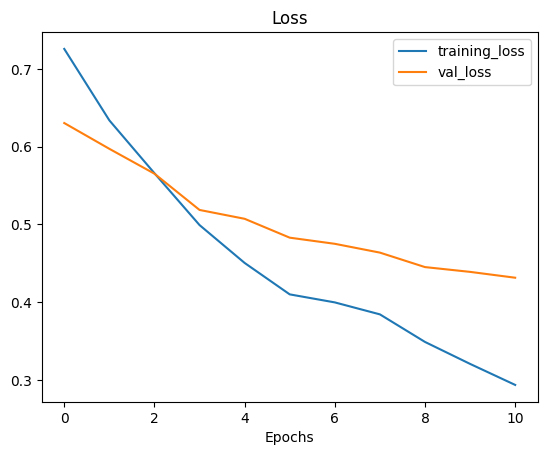

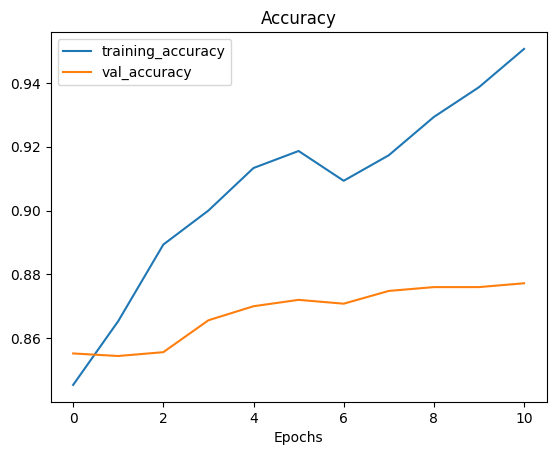

In [ ]:
plot_loss_curves(history_fine_tunned_model1)

## Exercise 3: Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

### Unfreezing the last 30 layers

In [ ]:
# We set the last 30 to be trainable
for layer in base_model.layers[-31:]:
  layer.trainable = True

In [ ]:
for num, layer in enumerate(base_model.layers):
  print(num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

### Creating a new instance of model 1

In [ ]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

model_1.load_weights(checkpoint_path)

In [ ]:
history2_fine_tunned_model1 = model_1.fit(train_data_10_percent, epochs=25,
                                         steps_per_epoch = len(train_data_10_percent),
                                         validation_data = test_data_10_percent,
                                         validation_steps = len(test_data_10_percent),
                                         initial_epoch = history_fine_tunned_model1.epoch[-1],
                                         callbacks=[checkpoint_callback])

Epoch 15/25
23/24 [===========================>..] - ETA: 0s - loss: 0.3317 - accuracy: 0.9293
Epoch 15: val_loss did not improve from 0.43152
24/24 [==============================] - 17s 404ms/step - loss: 0.3350 - accuracy: 0.9293 - val_loss: 0.4485 - val_accuracy: 0.8752
Epoch 16/25
23/24 [===========================>..] - ETA: 0s - loss: 0.3038 - accuracy: 0.9511
Epoch 16: val_loss did not improve from 0.43152
24/24 [==============================] - 7s 275ms/step - loss: 0.3021 - accuracy: 0.9520 - val_loss: 0.4466 - val_accuracy: 0.8748
Epoch 17/25
23/24 [===========================>..] - ETA: 0s - loss: 0.2725 - accuracy: 0.9647
Epoch 17: val_loss did not improve from 0.43152
24/24 [==============================] - 8s 319ms/step - loss: 0.2723 - accuracy: 0.9653 - val_loss: 0.4382 - val_accuracy: 0.8752
Epoch 18/25
23/24 [===========================>..] - ETA: 0s - loss: 0.2807 - accuracy: 0.9579
Epoch 18: val_loss did not improve from 0.43152
24/24 [===========================

In [ ]:
model_1.evaluate(test_data_10_percent)

79/79 [==============================] - 5s 62ms/step - loss: 0.4074 - accuracy: 0.8776


[0.4073758125305176, 0.8776000142097473]

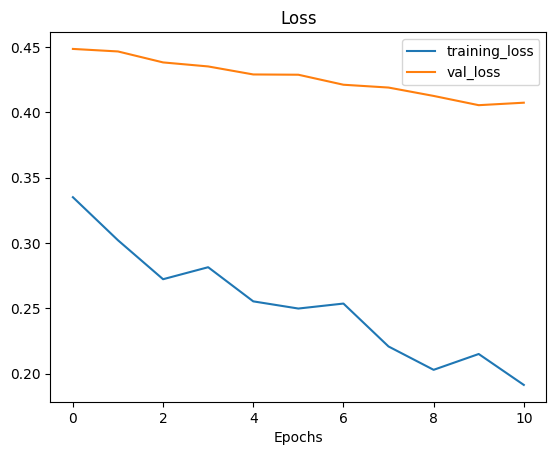

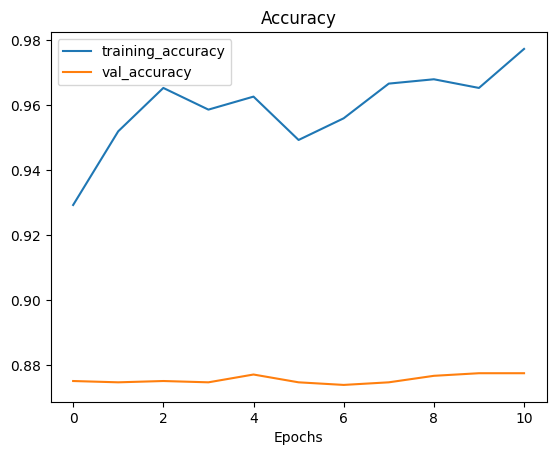

In [ ]:
plot_loss_curves(history2_fine_tunned_model1)

## Exercise 4: Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [ ]:
len(train_data_10_percent.class_names)

10

In [ ]:
def visualize_image(dataset):
  """
  Visualizes a random image from any dataset (train or test) and of any class and
  makes a prediction on it using one of the models that we trained.
  """
  class_names = dataset.class_names

  image_batch , label_batch = dataset.as_numpy_iterator().next()
  batch_prob = [model_1.predict(tf.expand_dims(img , axis = 0)) for img in image_batch]
  batch_preds = [class_names[np.argmax(prob)] for prob in batch_prob]

  plt.figure(figsize= (10 , 10))
  for i in range(4):
    ax = plt.subplot(2, 2 , i + 1)
    if class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      title_color = 'g'
    else:
      title_color = 'r'
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"actual: {class_names[np.argmax(label_batch[i])]}, pred: {batch_preds[i]}, prob: {batch_prob[i].max():.2f}",
              fontsize=10, c = title_color)
    plt.axis('off')


1/1 [==============================] - 0s 25ms/step


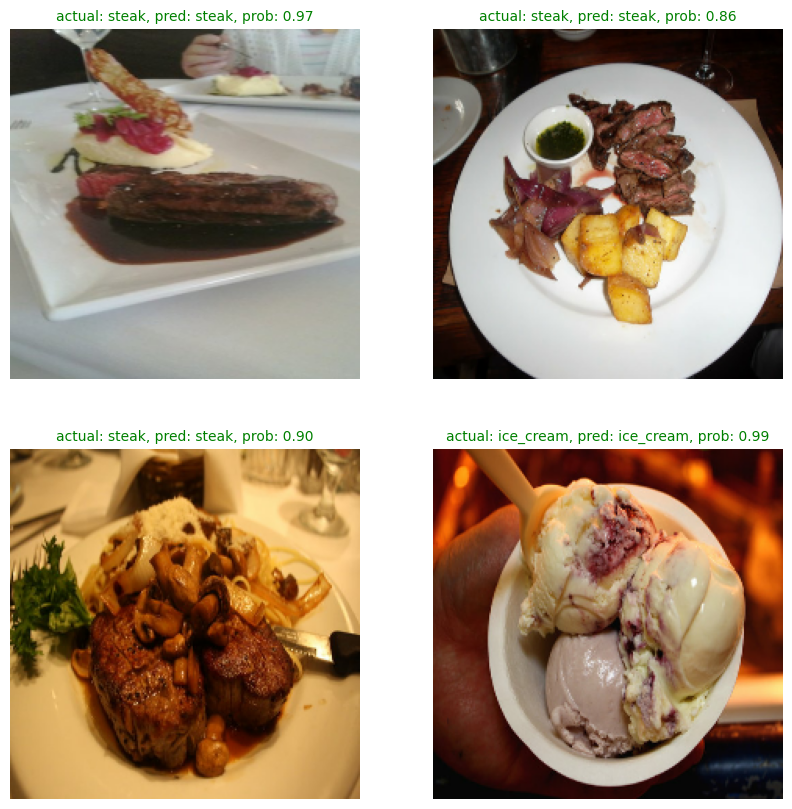

In [ ]:
visualize_image(train_data_10_percent)